In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import time
import matplotlib.pyplot as plt
from torchinfo import summary

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Step 1: Load and explore the data
print("Loading data...")
train_data = pd.read_csv('train_02.csv', header=None, names=['class_index', 'description'], skiprows=1)
test_data = pd.read_csv('test_02.csv', header=None, names=['class_index', 'description'], skiprows=1)


print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Class distribution in training data: {Counter(train_data['class_index'])}")

Using device: cuda
Loading data...
Train data shape: (120000, 2)
Test data shape: (7600, 2)
Class distribution in training data: Counter({3: 30000, 4: 30000, 2: 30000, 1: 30000})


In [3]:
def clean_text(text):
  
    import re
    text = re.sub(r'\\+', ' ', text)
    text = text.replace('\\n', ' ').replace('\\t', ' ').replace('\\r', ' ')
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'[^\w\s.,!?]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

In [4]:
class NewsDataset(Dataset):
    def __init__(self, dataframe, max_len=100, min_len=10):
        self.class_index = dataframe['class_index'].values
        self.descriptions = dataframe['description'].values
        self.max_len = max_len
        self.min_len = min_len
        
    def __len__(self):
        return len(self.class_index)
    
    def __getitem__(self, idx):
        text = self.descriptions[idx]

        text = clean_text(text)
        
        if len(text) < self.min_len:
            text = text + " " * (self.min_len - len(text))
        
        # chuyen qua ascii
        char_seq = []
        for c in text[:self.max_len]:
            try:
            
                val = ord(c)
                if 0 <= val < 128:
                    char_seq.append(val)
                else:
                    char_seq.append(32)  
            except:
                char_seq.append(32)  
        
        
        if len(char_seq) < self.max_len:
            char_seq = char_seq + [0] * (self.max_len - len(char_seq))
        
       
        x = torch.tensor(char_seq, dtype=torch.float32) / 127.0 
        
        y = torch.tensor(self.class_index[idx] - 1, dtype=torch.long)
        
        return x, y

In [5]:
MAX_LEN = 500
BATCH_SIZE = 128

train_dataset = NewsDataset(train_data, max_len=MAX_LEN)
test_dataset = NewsDataset(test_data, max_len=MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
class NewsClassifier(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, num_layers=3, output_dim=4, dropout=0.3):
        super(NewsClassifier, self).__init__()

        self.embedding = nn.Linear(1, input_dim)

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False 
        )

        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=1)
        )

        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(2)  # (batch, seq_len, 1)
        x = self.embedding(x)  # (batch, seq_len, input_dim)

        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim)

        attn_weights = self.attention(lstm_out)  # (batch, seq_len, 1)
        context = torch.bmm(attn_weights.transpose(1, 2), lstm_out)  # (batch, 1, hidden_dim)
        context = context.squeeze(1)  # (batch, hidden_dim)

        out = self.fc1(context)
        out = self.dropout1(out)
        out = self.relu(out)
        out = self.fc2(out)

        return out


In [7]:

INPUT_DIM = 16
HIDDEN_DIM = 128
NUM_LAYERS = 3
model = NewsClassifier(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    output_dim=4
)
model = model.to(device)


print(summary(model, input_size=(BATCH_SIZE, MAX_LEN), dtypes=[torch.float32]))

Layer (type:depth-idx)                   Output Shape              Param #
NewsClassifier                           [128, 4]                  --
├─Linear: 1-1                            [128, 500, 16]            32
├─LSTM: 1-2                              [128, 500, 128]           338,944
├─Sequential: 1-3                        [128, 500, 1]             --
│    └─Linear: 2-1                       [128, 500, 128]           16,512
│    └─Tanh: 2-2                         [128, 500, 128]           --
│    └─Linear: 2-3                       [128, 500, 1]             129
│    └─Softmax: 2-4                      [128, 500, 1]             --
├─Linear: 1-4                            [128, 128]                16,512
├─Dropout: 1-5                           [128, 128]                --
├─ReLU: 1-6                              [128, 128]                --
├─Linear: 1-7                            [128, 4]                  516
Total params: 372,645
Trainable params: 372,645
Non-trainable params: 

In [9]:
def count_parameters(model):
    total_params = 0
    param_details = []
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            params = param.numel()
            total_params += params
            param_details.append((name, params))
            
    return total_params, param_details

total_params, param_details = count_parameters(model)
print("\nModel Architecture:")
print(model)
print("\nModel Parameters:")
for name, params in param_details:
    print(f"{name}: {params:,} parameters")
print(f"Total trainable parameters: {total_params:,}")


Model Architecture:
NewsClassifier(
  (embedding): Linear(in_features=1, out_features=16, bias=True)
  (lstm): LSTM(16, 128, num_layers=3, batch_first=True, dropout=0.3)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Softmax(dim=1)
  )
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

Model Parameters:
embedding.weight: 16 parameters
embedding.bias: 16 parameters
lstm.weight_ih_l0: 8,192 parameters
lstm.weight_hh_l0: 65,536 parameters
lstm.bias_ih_l0: 512 parameters
lstm.bias_hh_l0: 512 parameters
lstm.weight_ih_l1: 65,536 parameters
lstm.weight_hh_l1: 65,536 parameters
lstm.bias_ih_l1: 512 parameters
lstm.bias_hh_l1: 512 parameters
lstm.weight_ih_l2: 65,536 parameters
lstm.weight_hh_l2: 65,536 parameters
lstm.bias_ih_l2: 512 

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)


In [11]:

def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [12]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [13]:

print("Starting training...")
num_epochs = 15
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    start_time = time.time()
    
   
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    
    test_loss, test_acc, preds, labels = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Update learning rate
    scheduler.step(test_loss)
    
    elapsed_time = time.time() - start_time
    
    print(f"Epoch {epoch+1}/{num_epochs}, Time: {elapsed_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    
    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        print("\nClassification Report:")
        target_names = ['World', 'Sports', 'Business', 'Science and Technology']
        print(classification_report(labels, preds, target_names=target_names))
    
    print("-" * 60)

Starting training...
Epoch 1/15, Time: 247.47s
Train Loss: 1.3531, Train Acc: 0.3065
Test Loss: 1.2986, Test Acc: 0.3586
------------------------------------------------------------
Epoch 2/15, Time: 243.12s
Train Loss: 1.2565, Train Acc: 0.3993
Test Loss: 1.1693, Test Acc: 0.4682
------------------------------------------------------------
Epoch 3/15, Time: 243.54s
Train Loss: 1.0692, Train Acc: 0.5327
Test Loss: 0.9382, Test Acc: 0.6120
------------------------------------------------------------
Epoch 4/15, Time: 243.89s
Train Loss: 0.8636, Train Acc: 0.6486
Test Loss: 0.7680, Test Acc: 0.6991
------------------------------------------------------------
Epoch 5/15, Time: 243.14s
Train Loss: 0.7430, Train Acc: 0.7077
Test Loss: 0.6844, Test Acc: 0.7367

Classification Report:
                        precision    recall  f1-score   support

                 World       0.70      0.82      0.75      1900
                Sports       0.81      0.82      0.82      1900
              Busi

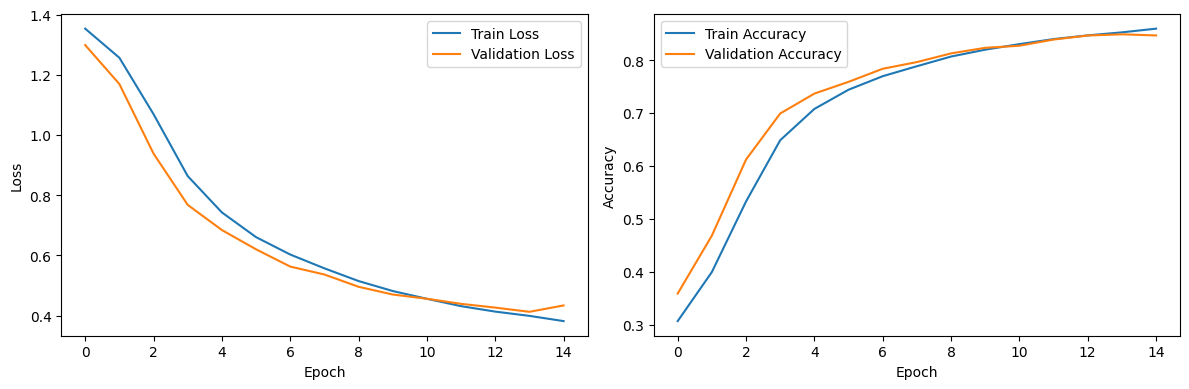

Final Test Loss: 0.4341, Final Test Accuracy: 0.8467

Final Classification Report:
                        precision    recall  f1-score   support

                 World       0.82      0.90      0.86      1900
                Sports       0.91      0.91      0.91      1900
              Business       0.87      0.74      0.80      1900
Science and Technology       0.79      0.84      0.82      1900

              accuracy                           0.85      7600
             macro avg       0.85      0.85      0.85      7600
          weighted avg       0.85      0.85      0.85      7600



In [14]:
# Plot training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('LSTMtraining_curves.png')
plt.show()

# Final evaluation
final_test_loss, final_test_acc, final_preds, final_labels = evaluate(model, test_loader, criterion, device)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_acc:.4f}")

print("\nFinal Classification Report:")
target_names = ['World', 'Sports', 'Business', 'Science and Technology']
print(classification_report(final_labels, final_preds, target_names=target_names))

In [22]:
import random
import torch

# Đảm bảo mô hình đang ở chế độ đánh giá
model.eval()

# Danh sách tên nhãn tương ứng với chỉ số (0 → 3)
label_names = ['World', 'Sports', 'Business', 'Science and Technology']

# Lấy 5 chỉ số ngẫu nhiên từ test_dataset
sample_indices = random.sample(range(len(test_dataset)), 5)

print("\n Dự đoán 5 mô tả ngẫu nhiên từ tập test:\n")
for idx in sample_indices:
    # Lấy input và nhãn thực từ dataset
    input_tensor, true_label = test_dataset[idx]
    description = test_data.iloc[idx]['description']

    # Đưa input về đúng shape và chuyển lên GPU nếu cần
    input_tensor = input_tensor.unsqueeze(0).to(device)

    # Dự đoán nhãn
    with torch.no_grad():
        output = model(input_tensor)
        predicted_label = torch.argmax(output, dim=1).item()

    # In kết quả
    print(f" Văn bản    : {description[:200]}{'...' if len(description) > 200 else ''}")
    print(f" Nhãn đúng  : {label_names[true_label]}")
    print(f" Dự đoán    : {label_names[predicted_label]}")
    print("-" * 90)



 Dự đoán 5 mô tả ngẫu nhiên từ tập test:

 Văn bản    : Michael Phelps won the gold medal in the 400 individual medley and set a world record in a time of 4 minutes 8.26 seconds.
 Nhãn đúng  : Sports
 Dự đoán    : Sports
------------------------------------------------------------------------------------------
 Văn bản    : Tokyo stocks finished sharply higher Monday, fueled by Wall Street #39;s gains last week. The US dollar was higher against the Japanese yen.
 Nhãn đúng  : Business
 Dự đoán    : Business
------------------------------------------------------------------------------------------
 Văn bản    :  STOCKHOLM (Reuters) - Andre Agassi marched into the  Stockholm Open semifinals Friday, beating Spanish eighth seed  Fernando Verdasco 7-6, 6-2 in his toughest match of the  tournament.
 Nhãn đúng  : Sports
 Dự đoán    : Sports
------------------------------------------------------------------------------------------
 Văn bản    : LNM Holdings has steelmaking operations in eight

# Cải thiện sử dụng Bi-LSTM

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import time
import matplotlib.pyplot as plt
from torchinfo import summary

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Step 1: Load and explore the data
print("Loading data...")
train_data = pd.read_csv('train_02.csv', header=None, names=['class_index', 'description'], skiprows=1)
test_data = pd.read_csv('test_02.csv', header=None, names=['class_index', 'description'], skiprows=1)


print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Class distribution in training data: {Counter(train_data['class_index'])}")

Using device: cuda
Loading data...
Train data shape: (120000, 2)
Test data shape: (7600, 2)
Class distribution in training data: Counter({3: 30000, 4: 30000, 2: 30000, 1: 30000})


In [3]:
def clean_text(text):
    
    import re
    
 
    text = re.sub(r'\\+', ' ', text)
    text = text.replace('\\n', ' ').replace('\\t', ' ').replace('\\r', ' ')
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'[^\w\s.,!?]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

In [4]:
class NewsDataset(Dataset):
    def __init__(self, dataframe, max_len=100, min_len=10):
        self.class_index = dataframe['class_index'].values
        self.descriptions = dataframe['description'].values
        self.max_len = max_len
        self.min_len = min_len
        
    def __len__(self):
        return len(self.class_index)
    
    def __getitem__(self, idx):
        text = self.descriptions[idx]
        
       
        text = clean_text(text)
        
        if len(text) < self.min_len:
            text = text + " " * (self.min_len - len(text))
        
        char_seq = []
        for c in text[:self.max_len]:
            try:
            
                val = ord(c)
                if 0 <= val < 128:
                    char_seq.append(val)
                else:
                    char_seq.append(32) 
            except:
                char_seq.append(32) 
        
    
        if len(char_seq) < self.max_len:
            char_seq = char_seq + [0] * (self.max_len - len(char_seq))
        
    
        x = torch.tensor(char_seq, dtype=torch.float32) / 127.0
        
        y = torch.tensor(self.class_index[idx] - 1, dtype=torch.long)
        
        return x, y

In [5]:
MAX_LEN = 500
BATCH_SIZE = 128


train_dataset = NewsDataset(train_data, max_len=MAX_LEN)
test_dataset = NewsDataset(test_data, max_len=MAX_LEN)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
class NewsClassifier(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, num_layers=3, output_dim=4, dropout=0.3):
        super(NewsClassifier, self).__init__()
        
        self.embedding = nn.Linear(1, input_dim)
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=1)
        )
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):

        x = x.unsqueeze(2)

        x = self.embedding(x)

        lstm_out, _ = self.lstm(x)
        
        attn_weights = self.attention(lstm_out)  # (batch_size, seq_len, 1)
        context = torch.bmm(attn_weights.transpose(1, 2), lstm_out)  # (batch_size, 1, hidden_dim*2)
        context = context.squeeze(1)  # (batch_size, hidden_dim*2)
        

        out = self.fc1(context)
        out = self.dropout1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out

In [7]:

INPUT_DIM = 16
HIDDEN_DIM = 128
NUM_LAYERS = 3
model = NewsClassifier(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    output_dim=4
)
model = model.to(device)


print(summary(model, input_size=(BATCH_SIZE, MAX_LEN), dtypes=[torch.float32]))

Layer (type:depth-idx)                   Output Shape              Param #
NewsClassifier                           [128, 4]                  --
├─Linear: 1-1                            [128, 500, 16]            32
├─LSTM: 1-2                              [128, 500, 256]           940,032
├─Sequential: 1-3                        [128, 500, 1]             --
│    └─Linear: 2-1                       [128, 500, 128]           32,896
│    └─Tanh: 2-2                         [128, 500, 128]           --
│    └─Linear: 2-3                       [128, 500, 1]             129
│    └─Softmax: 2-4                      [128, 500, 1]             --
├─Linear: 1-4                            [128, 128]                32,896
├─Dropout: 1-5                           [128, 128]                --
├─ReLU: 1-6                              [128, 128]                --
├─Linear: 1-7                            [128, 4]                  516
Total params: 1,006,501
Trainable params: 1,006,501
Non-trainable para

In [8]:
def count_parameters(model):
    total_params = 0
    param_details = []
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            params = param.numel()
            total_params += params
            param_details.append((name, params))
            
    return total_params, param_details

In [9]:
total_params, param_details = count_parameters(model)
print("\nModel Architecture:")
print(model)
print("\nModel Parameters:")
for name, params in param_details:
    print(f"{name}: {params:,} parameters")
print(f"Total trainable parameters: {total_params:,}")


Model Architecture:
NewsClassifier(
  (embedding): Linear(in_features=1, out_features=16, bias=True)
  (lstm): LSTM(16, 128, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Softmax(dim=1)
  )
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

Model Parameters:
embedding.weight: 16 parameters
embedding.bias: 16 parameters
lstm.weight_ih_l0: 8,192 parameters
lstm.weight_hh_l0: 65,536 parameters
lstm.bias_ih_l0: 512 parameters
lstm.bias_hh_l0: 512 parameters
lstm.weight_ih_l0_reverse: 8,192 parameters
lstm.weight_hh_l0_reverse: 65,536 parameters
lstm.bias_ih_l0_reverse: 512 parameters
lstm.bias_hh_l0_reverse: 512 parameters
lstm.weight_ih_l1: 131,072 parameters
lstm.w

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)


In [11]:
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [12]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [13]:
print("Starting training...")
num_epochs = 15
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    start_time = time.time()
 
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    

    test_loss, test_acc, preds, labels = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    

    scheduler.step(test_loss)
    
    elapsed_time = time.time() - start_time
    
    print(f"Epoch {epoch+1}/{num_epochs}, Time: {elapsed_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    

    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        print("\nClassification Report:")
        target_names = ['World', 'Sports', 'Business', 'Science and Technology']
        print(classification_report(labels, preds, target_names=target_names))
    
    print("-" * 60)

Starting training...
Epoch 1/15, Time: 297.98s
Train Loss: 1.3691, Train Acc: 0.2992
Test Loss: 1.2984, Test Acc: 0.3707
------------------------------------------------------------
Epoch 2/15, Time: 298.35s
Train Loss: 1.2742, Train Acc: 0.3883
Test Loss: 1.1935, Test Acc: 0.4447
------------------------------------------------------------
Epoch 3/15, Time: 299.20s
Train Loss: 1.0923, Train Acc: 0.5191
Test Loss: 0.9258, Test Acc: 0.6193
------------------------------------------------------------
Epoch 4/15, Time: 299.80s
Train Loss: 0.8272, Train Acc: 0.6668
Test Loss: 0.6961, Test Acc: 0.7305
------------------------------------------------------------
Epoch 5/15, Time: 299.94s
Train Loss: 0.6697, Train Acc: 0.7412
Test Loss: 0.6003, Test Acc: 0.7762

Classification Report:
                        precision    recall  f1-score   support

                 World       0.73      0.83      0.77      1900
                Sports       0.84      0.88      0.86      1900
              Busi

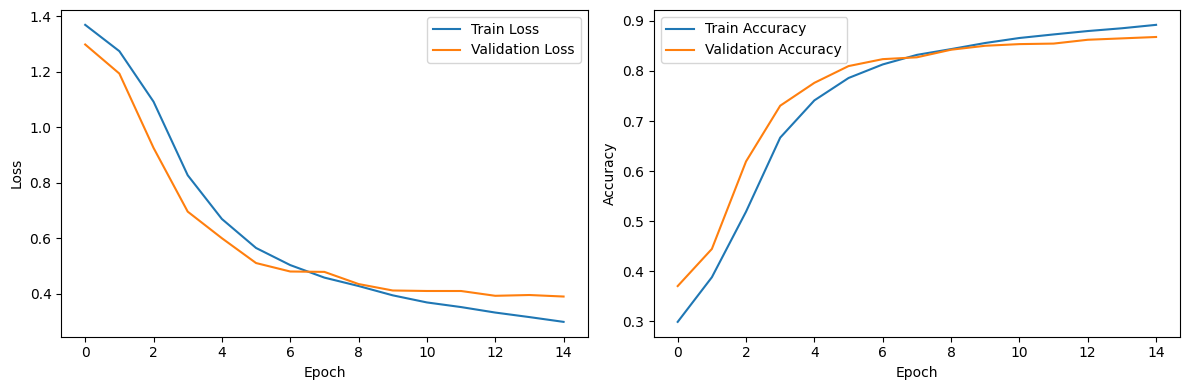

Final Test Loss: 0.3902, Final Test Accuracy: 0.8676

Final Classification Report:
                        precision    recall  f1-score   support

                 World       0.87      0.90      0.88      1900
                Sports       0.90      0.96      0.93      1900
              Business       0.85      0.81      0.83      1900
Science and Technology       0.85      0.80      0.82      1900

              accuracy                           0.87      7600
             macro avg       0.87      0.87      0.87      7600
          weighted avg       0.87      0.87      0.87      7600



In [15]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('newtraining_curves.png')
plt.show()


final_test_loss, final_test_acc, final_preds, final_labels = evaluate(model, test_loader, criterion, device)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_acc:.4f}")

print("\nFinal Classification Report:")
target_names = ['World', 'Sports', 'Business', 'Science and Technology']
print(classification_report(final_labels, final_preds, target_names=target_names))

In [16]:
import random
import torch

model.eval()

label_names = ['World', 'Sports', 'Business', 'Science and Technology']

sample_indices = random.sample(range(len(test_dataset)), 5)

print("\n Dự đoán 5 mô tả ngẫu nhiên từ tập test:\n")
for idx in sample_indices:

    input_tensor, true_label = test_dataset[idx]
    description = test_data.iloc[idx]['description']

    
    input_tensor = input_tensor.unsqueeze(0).to(device)


    with torch.no_grad():
        output = model(input_tensor)
        predicted_label = torch.argmax(output, dim=1).item()

 
    print(f" Văn bản    : {description[:200]}{'...' if len(description) > 200 else ''}")
    print(f" Nhãn đúng  : {label_names[true_label]}")
    print(f" Dự đoán    : {label_names[predicted_label]}")
    print("-" * 90)



 Dự đoán 5 mô tả ngẫu nhiên từ tập test:

 Văn bản    : Sales of server systems rose 7.7 percent globally in the second quarter to \$11.55 billion as demand for Information Technology remained strong after a three year downturn, market research firm Gartne...
 Nhãn đúng  : Science and Technology
 Dự đoán    : Business
------------------------------------------------------------------------------------------
 Văn bản    : Lacie today introduced a new series of external harddrives with SATA interface at the SMAU trade show in Milan, Italy. The drives are available in capacities up to 400 GByte.
 Nhãn đúng  : Science and Technology
 Dự đoán    : Science and Technology
------------------------------------------------------------------------------------------
 Văn bản    : GUANTANAMO BAY NAVAL BASE, Cuba - Osama bin Laden's chauffeur was officially charged Tuesday in the first U.S. military tribunal since World War II, appearing at a pretrial hearing where his lawyer ch...
 Nhãn đúng  : Wo

# cải tiến sử dụng Bi-LSTM và tăng cường xử lý dữ liệu với tokenize và stopword

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import time
import matplotlib.pyplot as plt
from torchinfo import summary
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("Loading data...")
train_data = pd.read_csv('train_02.csv', header=None, names=['class_index', 'description'], skiprows=1)
test_data = pd.read_csv('test_02.csv', header=None, names=['class_index', 'description'], skiprows=1)

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Class distribution in training data: {Counter(train_data['class_index'])}")

Using device: cuda
Loading data...
Train data shape: (120000, 2)
Test data shape: (7600, 2)
Class distribution in training data: Counter({3: 30000, 4: 30000, 2: 30000, 1: 30000})


In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Pc Nguyen
[nltk_data]     Phuc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Pc Nguyen
[nltk_data]     Phuc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
def clean_text(text):
    import re
  
    text = re.sub(r'\\+', ' ', text)
    text = text.replace('\\n', ' ').replace('\\t', ' ').replace('\\r', ' ')
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'[^\w\s.,!?]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()


    tokens = word_tokenize(text.lower())

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]

    return ' '.join(tokens)

In [5]:
class NewsDataset(Dataset):
    def __init__(self, dataframe, max_len=100, min_len=10):
        self.class_index = dataframe['class_index'].values
        self.descriptions = dataframe['description'].values
        self.max_len = max_len
        self.min_len = min_len

    def __len__(self):
        return len(self.class_index)

    def __getitem__(self, idx):
        text = self.descriptions[idx]
        text = clean_text(text)
        if len(text) < self.min_len:
            text = text + " " * (self.min_len - len(text))

        char_seq = []
        for c in text[:self.max_len]:
            try:
                val = ord(c)
                if 0 <= val < 128:
                    char_seq.append(val)
                else:
                    char_seq.append(32)
            except:
                char_seq.append(32)

        if len(char_seq) < self.max_len:
            char_seq = char_seq + [0] * (self.max_len - len(char_seq))

        x = torch.tensor(char_seq, dtype=torch.float32) / 127.0
        y = torch.tensor(self.class_index[idx] - 1, dtype=torch.long)
        return x, y


In [6]:
MAX_LEN = 500
BATCH_SIZE = 128

train_dataset = NewsDataset(train_data, max_len=MAX_LEN)
test_dataset = NewsDataset(test_data, max_len=MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
class NewsClassifier(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, num_layers=3, output_dim=4, dropout=0.3):
        super(NewsClassifier, self).__init__()
        self.embedding = nn.Linear(1, input_dim)
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=1)
        )
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(2)
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        attn_weights = self.attention(lstm_out)
        context = torch.bmm(attn_weights.transpose(1, 2), lstm_out).squeeze(1)
        out = self.fc1(context)
        out = self.dropout1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [8]:
INPUT_DIM = 16
HIDDEN_DIM = 128
NUM_LAYERS = 3
model = NewsClassifier(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, output_dim=4)
model = model.to(device)
print(summary(model, input_size=(BATCH_SIZE, MAX_LEN), dtypes=[torch.float32]))

Layer (type:depth-idx)                   Output Shape              Param #
NewsClassifier                           [128, 4]                  --
├─Linear: 1-1                            [128, 500, 16]            32
├─LSTM: 1-2                              [128, 500, 256]           940,032
├─Sequential: 1-3                        [128, 500, 1]             --
│    └─Linear: 2-1                       [128, 500, 128]           32,896
│    └─Tanh: 2-2                         [128, 500, 128]           --
│    └─Linear: 2-3                       [128, 500, 1]             129
│    └─Softmax: 2-4                      [128, 500, 1]             --
├─Linear: 1-4                            [128, 128]                32,896
├─Dropout: 1-5                           [128, 128]                --
├─ReLU: 1-6                              [128, 128]                --
├─Linear: 1-7                            [128, 4]                  516
Total params: 1,006,501
Trainable params: 1,006,501
Non-trainable para

In [9]:
def count_parameters(model):
    total_params = 0
    param_details = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            params = param.numel()
            total_params += params
            param_details.append((name, params))
    return total_params, param_details

total_params, param_details = count_parameters(model)
print("\nModel Architecture:")
print(model)
print("\nModel Parameters:")
for name, params in param_details:
    print(f"{name}: {params:,} parameters")
print(f"Total trainable parameters: {total_params:,}")


Model Architecture:
NewsClassifier(
  (embedding): Linear(in_features=1, out_features=16, bias=True)
  (lstm): LSTM(16, 128, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Softmax(dim=1)
  )
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

Model Parameters:
embedding.weight: 16 parameters
embedding.bias: 16 parameters
lstm.weight_ih_l0: 8,192 parameters
lstm.weight_hh_l0: 65,536 parameters
lstm.bias_ih_l0: 512 parameters
lstm.bias_hh_l0: 512 parameters
lstm.weight_ih_l0_reverse: 8,192 parameters
lstm.weight_hh_l0_reverse: 65,536 parameters
lstm.bias_ih_l0_reverse: 512 parameters
lstm.bias_hh_l0_reverse: 512 parameters
lstm.weight_ih_l1: 131,072 parameters
lstm.w

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

In [11]:
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [12]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels


In [13]:
print("Starting training...")
num_epochs = 15
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_loss, test_acc, preds, labels = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    scheduler.step(test_loss)
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Time: {elapsed_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        print("\nClassification Report:")
        target_names = ['World', 'Sports', 'Business', 'Science and Technology']
        print(classification_report(labels, preds, target_names=target_names))
    print("-" * 60)


Starting training...
Epoch 1/15, Time: 347.11s
Train Loss: 1.3707, Train Acc: 0.3010
Test Loss: 1.3602, Test Acc: 0.3239
------------------------------------------------------------
Epoch 2/15, Time: 347.14s
Train Loss: 1.3651, Train Acc: 0.3154
Test Loss: 1.3619, Test Acc: 0.3151
------------------------------------------------------------
Epoch 3/15, Time: 347.35s
Train Loss: 1.3643, Train Acc: 0.3172
Test Loss: 1.3588, Test Acc: 0.3233
------------------------------------------------------------
Epoch 4/15, Time: 347.54s
Train Loss: 1.3636, Train Acc: 0.3173
Test Loss: 1.3635, Test Acc: 0.3129
------------------------------------------------------------
Epoch 5/15, Time: 347.58s
Train Loss: 1.3594, Train Acc: 0.3200
Test Loss: 1.3174, Test Acc: 0.3622

Classification Report:
                        precision    recall  f1-score   support

                 World       0.33      0.33      0.33      1900
                Sports       0.40      0.62      0.49      1900
              Busi

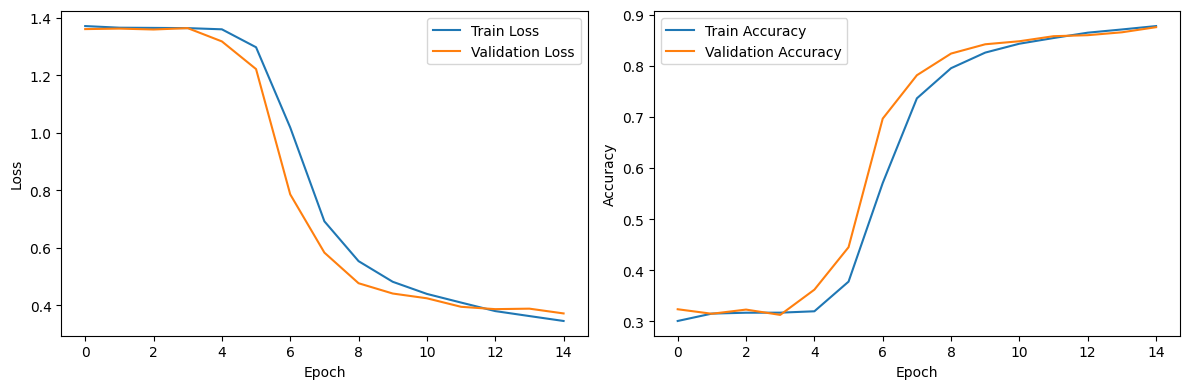

Final Test Loss: 0.3721, Final Test Accuracy: 0.8755

Final Classification Report:
                        precision    recall  f1-score   support

                 World       0.91      0.87      0.89      1900
                Sports       0.90      0.96      0.93      1900
              Business       0.85      0.84      0.84      1900
Science and Technology       0.84      0.84      0.84      1900

              accuracy                           0.88      7600
             macro avg       0.88      0.88      0.88      7600
          weighted avg       0.88      0.88      0.88      7600



In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('newtraining_curves.png')
plt.show()

final_test_loss, final_test_acc, final_preds, final_labels = evaluate(model, test_loader, criterion, device)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_acc:.4f}")
print("\nFinal Classification Report:")
target_names = ['World', 'Sports', 'Business', 'Science and Technology']
print(classification_report(final_labels, final_preds, target_names=target_names))

In [15]:
import random
import torch

model.eval()

label_names = ['World', 'Sports', 'Business', 'Science and Technology']


sample_indices = random.sample(range(len(test_dataset)), 5)

print("\n Dự đoán 5 mô tả ngẫu nhiên từ tập test:\n")
for idx in sample_indices:

    input_tensor, true_label = test_dataset[idx]
    description = test_data.iloc[idx]['description']


    input_tensor = input_tensor.unsqueeze(0).to(device)


    with torch.no_grad():
        output = model(input_tensor)
        predicted_label = torch.argmax(output, dim=1).item()


    print(f" Văn bản    : {description[:200]}{'...' if len(description) > 200 else ''}")
    print(f" Nhãn đúng  : {label_names[true_label]}")
    print(f" Dự đoán    : {label_names[predicted_label]}")
    print("-" * 90)



 Dự đoán 5 mô tả ngẫu nhiên từ tập test:

 Văn bản    : LOURDES, France - A frail Pope John Paul II, breathing heavily and gasping at times, celebrated an open-air Mass on Sunday for several hundred thousand pilgrims, many in wheelchairs, at a shrine to th...
 Nhãn đúng  : World
 Dự đoán    : World
------------------------------------------------------------------------------------------
 Văn bản    : The world's top air-express shipper said earnings soared on strong revenue growth in its international, ground and freight services.
 Nhãn đúng  : Business
 Dự đoán    : Business
------------------------------------------------------------------------------------------
 Văn bản    : FERRARI are to snub crucial talks at Heathrow today aimed at revolutionising Grand Prix racing. The Italian giants are the only team blocking radical changes that could save the leading outfits 
 Nhãn đúng  : Sports
 Dự đoán    : Sports
-------------------------------------------------------------------------